# Support Ticket Classification & Prioritization System

## Machine Learning Internship Task 2

This project builds an NLP-based system to automatically:
- Classify IT support tickets into categories
- Assign priority levels
- Improve operational efficiency for support teams

## Importing Required Libraries

We import all necessary libraries for:
- Data handling
- Text preprocessing
- Feature extraction
- Model training
- Model evaluation

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
import string

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

## Downloading Stopwords

We download the NLTK stopwords list for text preprocessing.
(This only needs to be done once.)

In [ ]:
nltk.download('stopwords')

## Loading the Dataset

We now load the IT Service Ticket dataset for analysis.

In [6]:
df = pd.read_csv("../data/all_tickets_processed_improved_v3.csv")

df.head()

,Document,Topic_group
0,connection with icon icon dear please setup ic...,Hardware
1,work experience user work experience user hi w...,Access
2,requesting for meeting requesting meeting hi p...,Hardware
3,reset passwords for external accounts re expir...,Access
4,mail verification warning hi has got attached ...,Miscellaneous


## Dataset Overview

We examine:
- Number of records
- Data types
- Distribution of ticket categories

In [9]:
df.info()
df['Topic_group'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47837 entries, 0 to 47836
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Document     47837 non-null  object
 1   Topic_group  47837 non-null  object
dtypes: object(2)
memory usage: 747.6+ KB


Topic_group
Hardware                 13617
HR Support               10915
Access                    7125
Miscellaneous             7060
Storage                   2777
Purchase                  2464
Internal Project          2119
Administrative rights     1760
Name: count, dtype: int64

## Inspecting Raw Text Samples

Before cleaning, we examine a few raw ticket texts 
to understand formatting, repetition, and noise patterns.

In [10]:
df['Document'].iloc[0]

'connection with icon icon dear please setup icon per icon engineers please let other details needed thanks lead'

## Text Preprocessing

We clean the raw ticket text to improve model performance.

The cleaning process includes:
- Converting to lowercase
- Removing punctuation
- Removing stopwords
- Removing extra whitespace

This ensures the model focuses only on meaningful content.

In [12]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Lowercase
    text = text.lower()
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenize (simple split)
    words = text.split()
    
    # Remove stopwords
    words = [word for word in words if word not in stop_words]
    
    # Join back to sentence
    cleaned_text = " ".join(words)
    
    return cleaned_text

### Improving Text Cleaning

We extend the standard stopword list to remove 
support-ticket specific polite and greeting words 
that do not contribute to classification.

In [14]:
custom_stopwords = {
    'dear', 'hi', 'hello', 'please', 'thanks', 
    'thank', 'regards', 'team'
}

stop_words = set(stopwords.words('english'))
stop_words.update(custom_stopwords)

def clean_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = text.split()
    words = [word for word in words if word not in stop_words]
    cleaned_text = " ".join(words)
    return cleaned_text

## Applying Text Cleaning

We apply the preprocessing function to all ticket documents.

In [17]:
df['cleaned_text'] = df['Document'].apply(clean_text)

df[['Document', 'cleaned_text']].head()

,Document,cleaned_text
0,connection with icon icon dear please setup ic...,connection icon icon setup icon per icon engin...
1,work experience user work experience user hi w...,work experience user work experience user work...
2,requesting for meeting requesting meeting hi p...,requesting meeting requesting meeting help fol...
3,reset passwords for external accounts re expir...,reset passwords external accounts expire days ...
4,mail verification warning hi has got attached ...,mail verification warning got attached address...


## Feature Extraction using TF-IDF

Machine Learning models require numerical input.
We convert cleaned ticket text into numerical vectors using 
Term Frequency – Inverse Document Frequency (TF-IDF).

TF-IDF helps:
- Capture important words
- Reduce impact of common words
- Represent text meaning numerically

In [18]:
tfidf = TfidfVectorizer(
    max_features=5000,   # Limit features for efficiency
    ngram_range=(1,2)    # Use unigrams + bigrams
)

X = tfidf.fit_transform(df['cleaned_text'])

y = df['Topic_group']

X.shape

(47837, 5000)

## Train–Test Split

To evaluate model performance, we split the dataset into:

- 80% Training Data  
- 20% Testing Data  

Stratified splitting is used to maintain the same class distribution 
across training and testing sets.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)

Training set size: (38269, 5000)
Testing set size: (9568, 5000)


## Ticket Category Classification Model

We train a Logistic Regression classifier to predict
the category of support tickets based on cleaned text features.

Why Logistic Regression?
- Strong performance in text classification
- Efficient on high-dimensional sparse data
- Suitable for multi-class classification

In [20]:
model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',  # Handle class imbalance
    random_state=42
)

model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

## Making Predictions on Test Data

We now evaluate the trained classifier
on unseen test data to measure performance.

In [21]:
y_pred = model.predict(X_test)

## Model Evaluation

We evaluate the classification model using:

- Accuracy
- Precision
- Recall
- F1-score
- Confusion Matrix

These metrics help us understand:
- Overall performance
- Class-wise prediction quality
- Areas where the model struggles

In [22]:
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.8550376254180602

Classification Report:

                       precision    recall  f1-score   support

               Access       0.90      0.89      0.89      1425
Administrative rights       0.67      0.88      0.76       352
           HR Support       0.89      0.84      0.87      2183
             Hardware       0.87      0.80      0.83      2724
     Internal Project       0.79      0.94      0.86       424
        Miscellaneous       0.80      0.87      0.84      1412
             Purchase       0.92      0.90      0.91       493
              Storage       0.85      0.92      0.88       555

             accuracy                           0.86      9568
            macro avg       0.84      0.88      0.85      9568
         weighted avg       0.86      0.86      0.86      9568



## Confusion Matrix Visualization

The confusion matrix shows how well the model distinguishes 
between different ticket categories.

This helps identify misclassification patterns.

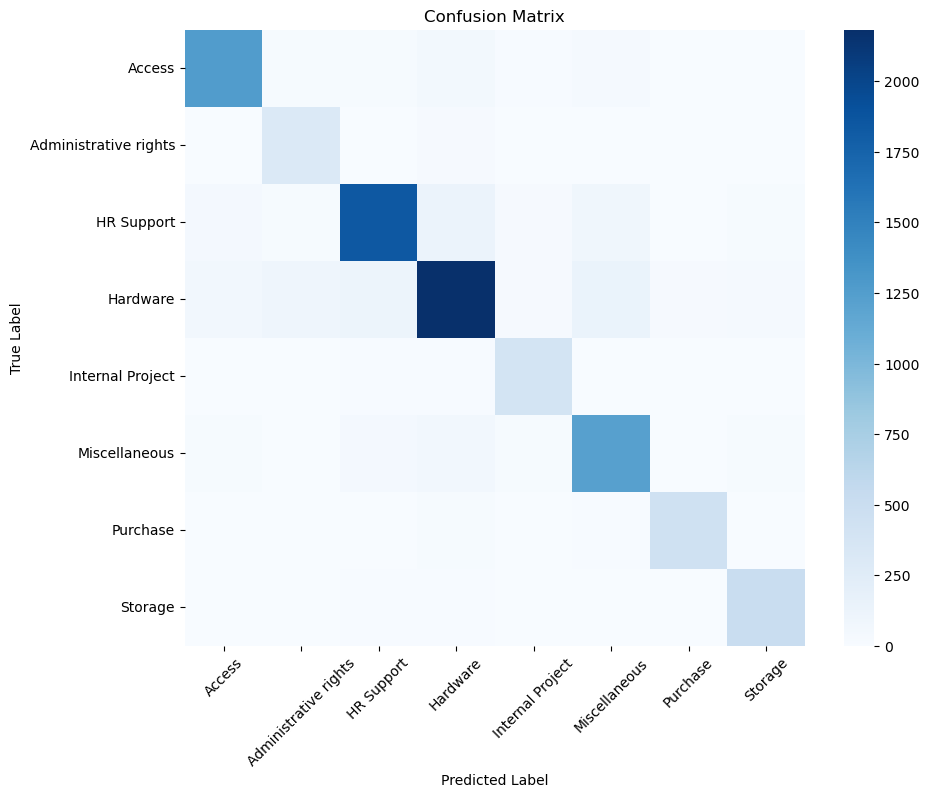

In [23]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
            xticklabels=model.classes_,
            yticklabels=model.classes_)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

## Ticket Priority Assignment Logic

Since the dataset does not include priority labels,
we design a rule-based priority assignment system.

Priority is determined using:

- Presence of urgency-related keywords
- Critical ticket categories
- Content severity indicators

Priority Levels:
- High
- Medium
- Low

In [24]:
urgent_keywords = {
    "urgent", "asap", "immediately", "critical",
    "down", "failure", "not working", "error",
    "unable", "issue", "blocked"
}

high_priority_categories = {
    "Hardware", 
    "Access", 
    "Administrative rights"
}

def assign_priority(text, category):
    text = text.lower()
    
    # Check urgent keywords
    if any(word in text for word in urgent_keywords):
        return "High"
    
    # Check critical categories
    if category in high_priority_categories:
        return "High"
    
    # Default medium
    return "Medium"

## Applying Priority Logic to Predictions

In [30]:
# Create results DataFrame
df_test_results = pd.DataFrame({
    "Text": df.loc[y_test.index, "Document"].values,
    "Predicted_Category": y_pred
})

# Apply priority logic
df_test_results["Priority"] = df_test_results.apply(
    lambda row: assign_priority(row["Text"], row["Predicted_Category"]),
    axis=1
)

# Show sample results
df_test_results.head()

,Text,Predicted_Category,Priority
0,project codes july pm codes hello please assig...,Internal Project,Low
1,new starter pop ad july re date merci ale ext ...,HR Support,Medium
2,add to thursday february re update thanks plea...,Miscellaneous,Low
3,create record net which points to thursday pm ...,Access,High
4,all buyers mail february pm buyers hello pleas...,Miscellaneous,Low


## Improved Priority Assignment Logic

We enhance the priority system to support three levels:

Priority Levels:
- High → Urgent or critical operational issues
- Medium → Normal support requests
- Low → Informational or non-blocking tickets

Priority is determined using:
- Urgency-related keywords
- Category-based severity
- Default fallback logic

In [31]:
# Define urgency-related keywords
urgent_keywords = {
    "urgent", "asap", "immediately", "critical",
    "down", "failure", "not working", "error",
    "unable", "blocked"
}

# Categories that are operationally critical
high_priority_categories = {
    "Hardware",
    "Access",
    "Administrative rights"
}

# Categories that are usually non-blocking
low_priority_categories = {
    "Internal Project",
    "Miscellaneous"
}

def assign_priority(text, category):
    text = text.lower()
    
    # Rule 1: Urgency keywords → High Priority
    if any(word in text for word in urgent_keywords):
        return "High"
    
    # Rule 2: Critical categories → High Priority
    if category in high_priority_categories:
        return "High"
    
    # Rule 3: Low-importance categories → Low Priority
    if category in low_priority_categories:
        return "Low"
    
    # Default → Medium Priority
    return "Medium"

df_test_results["Priority"].value_counts()

Priority
High      5271
Medium    2557
Low       1740
Name: count, dtype: int64

## Business Impact and Operational Benefits

This system helps support teams by:

- Automatically categorizing incoming tickets
- Reducing manual sorting time
- Identifying high-priority issues instantly
- Improving response times for critical problems
- Reducing backlog
- Improving customer satisfaction

With ~85% classification accuracy, the system can significantly
assist support managers in managing workload efficiently.

# Final Conclusion

In this project, we built a complete Support Ticket Classification 
and Prioritization system using Natural Language Processing (NLP) 
and Machine Learning techniques.

### What Was Done:

- Cleaned and preprocessed raw ticket text data
- Removed stopwords and irrelevant boilerplate language
- Converted text into numerical representations using TF-IDF
- Trained a Logistic Regression multi-class classifier
- Handled class imbalance using balanced class weights
- Evaluated performance using accuracy, precision, recall, F1-score
- Visualized results using a confusion matrix
- Designed a rule-based priority assignment system 
  (High / Medium / Low)

### Model Performance:

The classifier achieved approximately **85% accuracy**
across 8 ticket categories, demonstrating strong performance
for a real-world support dataset.

Class-wise F1-scores indicate consistent predictive capability
across most categories, with minor confusion in closely related ticket types.

### Business Impact:

This system provides direct operational benefits:

- Automatically categorizes incoming tickets
- Reduces manual sorting workload
- Instantly flags high-priority issues
- Speeds up response time for critical problems
- Improves support team efficiency
- Enhances customer satisfaction

### Overall Outcome:

The project successfully demonstrates how Machine Learning
can transform unstructured support ticket text into 
actionable operational insights.

This system can serve as a foundation for:

- Automated support pipelines
- Intelligent ticket routing
- SLA monitoring systems
- Real-time ticket dashboards

The model delivers both technical accuracy and 
practical business value — fulfilling the requirements 
of the internship task while simulating a real industry use case.